In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

### Dataset

In [2]:
#Read dataframe 
df = pd.read_csv('ctg.csv')
df

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Min,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0.000000,0.000000,0.000000,0.000000,0.0,0.0,73,0.5,43,...,126,62,2,0,120,137,121,73,1,2
1,132,0.006380,0.000000,0.006380,0.003190,0.0,0.0,17,2.1,0,...,198,68,6,1,141,136,140,12,0,1
2,133,0.003322,0.000000,0.008306,0.003322,0.0,0.0,16,2.1,0,...,198,68,5,1,141,135,138,13,0,1
3,134,0.002561,0.000000,0.007682,0.002561,0.0,0.0,16,2.4,0,...,170,53,11,0,137,134,137,13,1,1
4,132,0.006515,0.000000,0.008143,0.000000,0.0,0.0,16,2.4,0,...,170,53,9,0,137,136,138,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140,0.000000,0.000000,0.007426,0.000000,0.0,0.0,79,0.2,25,...,177,137,4,0,153,150,152,2,0,2
2122,140,0.000775,0.000000,0.006971,0.000000,0.0,0.0,78,0.4,22,...,169,103,6,0,152,148,151,3,1,2
2123,140,0.000980,0.000000,0.006863,0.000000,0.0,0.0,79,0.4,20,...,170,103,5,0,153,148,152,4,1,2
2124,140,0.000679,0.000000,0.006110,0.000000,0.0,0.0,78,0.4,27,...,169,103,6,0,152,147,151,4,1,2


In [3]:
#Split with ratio
#Train:Test = 0.7:0.3

train, test = train_test_split(df, test_size=0.3)

In [4]:
#Features & Labels

X_train = train[train.columns[:-1]].values
y_train = train[train.columns[-1]].values

X_test = test[test.columns[:-1]].values
y_test = test[test.columns[-1]].values


### Model

In [5]:
###Construct Model

#Declare hyperparameter options
model_params = {
    'n_estimators': [10, 15, 20, 25],
    'criterion': ['entropy', 'gini'],
    'max_features': ['sqrt', 'auto', 'log2', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6],
    'max_depth': [4,5,6,7],
}

#Initiate classifier
rf_model = RandomForestClassifier(random_state=123)
classifier = GridSearchCV(rf_model, model_params, cv=5)

#Train the grid search to find the best model
model = classifier.fit(X_train, y_train)
best_model = model.best_estimator_

#Print best hyperparameter set
pprint(best_model.get_params())


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


### Result

,precision,recall,f1-score,support
Normal,0.960317,0.966068,0.963184,501
Suspect,0.772152,0.762500,0.767296,80
Pathologic,0.945455,0.912281,0.928571,57
Weighted Average,0.935395,0.935737,0.935529,638


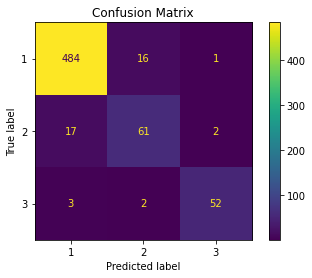

In [6]:
###Evaluation Metrics

#Predict using test data
y_pred = best_model.predict(X_test)

#Confusion matrix
disp = plot_confusion_matrix(best_model, X_test, y_test, display_labels=best_model.classes_)
disp.ax_.set_title("Confusion Matrix")
print(disp)

#Get evaluation metrics
report = classification_report(y_test, y_pred, digits=5, output_dict=True)

#Generate report in a dataframe
ev_metrics = pd.DataFrame(report).transpose()
ev_metrics['support'] = ev_metrics['support'].astype(int)
acc = ev_metrics.loc['accuracy'][0]
ev_metrics.drop(['accuracy', 'macro avg'], inplace=True)
ev_metrics.index = ['Normal', 'Suspect', 'Pathologic', 'Weighted Average']

#Style for weighted average
ev_metrics.style.set_table_styles({
    'Weighted Average': [{'selector': '',
         'props': [('border-top', '2px solid black')]}]
}, axis=1, overwrite=False)


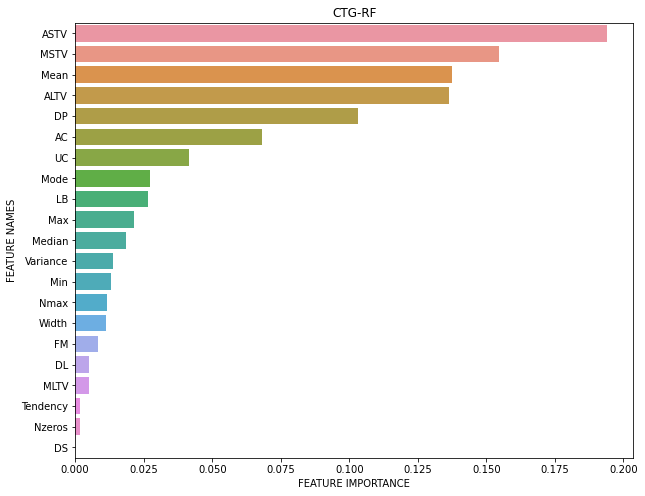

In [7]:
###Feature Importance

def plot_feature_importance(feature_importance,feature_names,title):

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=df['feature_importance'], y=df['feature_names'])
    #Add chart labels
    plt.title(title)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#Show ranked feature importances
plot_feature_importance(best_model.feature_importances_,df.columns[:-1],'CTG-RF')

### Edge Implementations

In [8]:
###Show all trees in this forest

print('Total Trees in this Forest are :', len(best_model.estimators_))
best_model.estimators_

Total Trees in this Forest are : 15


[DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=843828734),
 DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=914636141),
 DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=1228959102),
 DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=1840268610),
 DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=974319580),
 DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=819844194),
 DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=220395238),
 DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=1.0,
                        random_state=941243409)

In [9]:
###Show the structure of the first tree only

#This structure is the one we can use for rewriting the model in C++
print('All if-else statements from the tree\n')
print(export_text(best_model.estimators_[0], feature_names=list(df.columns[:-1])))

All if-else statements from the tree

|--- MSTV <= 0.65
|   |--- ASTV <= 59.50
|   |   |--- Min <= 148.50
|   |   |   |--- FM <= 0.02
|   |   |   |   |--- UC <= 0.00
|   |   |   |   |   |--- UC <= 0.00
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- UC >  0.00
|   |   |   |   |   |   |--- Max <= 146.00
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Max >  146.00
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- UC >  0.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- FM >  0.02
|   |   |   |   |--- class: 1.0
|   |   |--- Min >  148.50
|   |   |   |--- Mean <= 162.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- Mean >  162.50
|   |   |   |   |--- class: 0.0
|   |--- ASTV >  59.50
|   |   |--- ALTV <= 68.50
|   |   |   |--- ASTV <= 79.50
|   |   |   |   |--- ALTV <= 6.50
|   |   |   |   |   |--- Mean <= 148.50
|   |   |   |   |   |   |--- Min <= 89.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   

In [10]:
###Visualize tree if needed

# fig = plt.figure(figsize=(100, 100))
# plot_tree(best_model.estimators_[0], 
#           feature_names=df.columns[:-1],
#           class_names=df.columns[-1], 
#           filled=True, impurity=True, 
#           rounded=True)
# plt.show()


In [11]:
###Parse to C++

#This micromlgen is a useful parser for the model.
#We can also write our own parser, as long as
#the model's tree structure can be exported

from micromlgen import port

#Save best model in a file
lib = port(best_model, classmap={1:'Normal', 2:'Suspect', 3:'Pathologic'})

add_header = '#include "stdint.h"\n'
pos = lib.find('namespace')
updated_lib = lib[:pos] + add_header + lib[pos:]

add_index = '+1' #micromlgen can't start at 1, always 0.
pos = lib.find('return classIdx') + len('return classIdx')
updated_lib = lib[:pos] + add_index + lib[pos:]

with open('src/model.h', 'w') as f:
    print(updated_lib, file=f)

In [12]:
#On linux only, checking model size

# !ls -l 'src/model.h'

In [13]:
### Write test file to C++

#Downcast Python(float64 to float32) (C++ double to float)
test = test.copy()
test.reset_index(inplace=True, drop=True)
# test = test.round(6)
x_str = str(test[test.columns[:-1]].to_numpy().tolist())
y_str = str(test[test.columns[-1]].to_numpy().tolist())

row = test.shape[0]
col = test.shape[1]


#Write X_test
x_str = x_str.replace("[", "{").replace("]", "}")
with open('src/test_data.cc', 'w') as f:
    print(f'float x_test[{row}][{col}]=', file=f)
    print(x_str, file=f, end='')
    print(';', file=f)
    print('\n', file=f)
    
    
#Append y_test
y_str = y_str.replace("[", "{").replace("]", "}")
with open('src/test_data.cc', 'a') as f:
    print(f'int y_test[{row}]=', file=f)
    print(y_str, file=f, end='')
    print(';', file=f)
    
#Now create the header file (.h)
with open('src/test_data.h', 'w') as f:
    print(f'extern float x_test[{row}][{col}];', file=f)
    print(f'extern int y_test[{row}];', file=f)